In [1]:
from socket import gethostname
gethostname()

'hpc3-l18-05'

In [2]:
from dotenv import load_dotenv
load_dotenv()

True

In [24]:
import os
from sqlalchemy import create_engine
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

In [4]:
#establish connection
engine = create_engine(os.getenv('POSTGRE_DB_URL'))

#read the dialogues table into a pandas dataframe
df = pd.read_sql("SELECT * FROM summaries;", engine)
df.head()

,summary_id,dialogue_id,model_id,generated_summary,rouge_1,rouge_2,rouge_l,bert_precision,bert_recall,bert_f1,meteor,memory_summary_usage,time_summary_taken
0,1,1,mistral 7b,Doctor Hawkins greets Mr. Smith and asks why h...,0.351351,0.159091,0.324324,0.888796,0.906006,0.897319,0.505513,NaN,NaN
1,2,2,mistral 7b,Person1 greets Person2 and checks Ricky's vacc...,0.250000,0.000000,0.218750,0.836484,0.907462,0.870528,0.335816,NaN,NaN
2,3,3,mistral 7b,Person1 lost a set of five keys with a small f...,0.367347,0.074074,0.285714,0.880228,0.880754,0.880491,0.363356,NaN,NaN
3,4,4,mistral 7b,Person1 was upset that Person2 had a girlfrien...,0.233333,0.105263,0.166667,0.868038,0.871339,0.869685,0.304503,NaN,NaN
4,5,5,mistral 7b,Malik approaches Wen and Nikki at the dance fl...,0.392857,0.120482,0.392857,0.869606,0.924768,0.896339,0.529660,NaN,NaN


In [5]:
df.describe()

,summary_id,dialogue_id,rouge_1,rouge_2,rouge_l,bert_precision,bert_recall,bert_f1,meteor,memory_summary_usage,time_summary_taken
count,37753.000000,37753.000000,37753.000000,37753.000000,37753.000000,37753.000000,37753.000000,37753.000000,37753.000000,25326.000000,25326.000000
mean,18877.000000,6214.593648,0.272887,0.083755,0.248507,0.873916,0.883660,0.878600,0.314089,219.525862,0.785222
std,10898.496693,3586.353524,0.098921,0.071275,0.094605,0.019703,0.020777,0.016429,0.109128,152.158649,0.387565
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.679520,0.778998,0.753746,0.000000,72.212168,0.310299
25%,9439.000000,3108.000000,0.206897,0.031746,0.184211,0.861310,0.870581,0.868129,0.236820,88.260801,0.458209
50%,18877.000000,6212.000000,0.270833,0.071429,0.243902,0.873586,0.884263,0.878688,0.306122,212.465469,0.805934
75%,28315.000000,9322.000000,0.333333,0.121547,0.307692,0.886336,0.896970,0.889038,0.382858,281.496641,0.850908
max,37753.000000,12427.000000,0.818182,0.750000,0.818182,0.978980,0.980759,0.969209,0.871137,1190.739219,3.432660


In [6]:
df["model_id"].unique()

array(['mistral 7b', 'falcon 7b', 'llama 3 8b'], dtype=object)

In [8]:
df[df["model_id"] == "llama 3 8b"].describe()

,summary_id,dialogue_id,rouge_1,rouge_2,rouge_l,bert_precision,bert_recall,bert_f1,meteor,memory_summary_usage,time_summary_taken
count,12427.000000,12427.000000,12427.000000,12427.000000,12427.000000,12427.000000,12427.000000,12427.000000,12427.000000,12427.000000,12427.000000
mean,31540.000000,6214.000000,0.287068,0.094718,0.264146,0.869316,0.886671,0.877773,0.340625,337.338893,1.001355
std,3587.510232,3587.510232,0.094940,0.070203,0.091676,0.018029,0.021438,0.016572,0.106149,134.385868,0.376165
min,25327.000000,1.000000,0.000000,0.000000,0.000000,0.695600,0.778998,0.768855,0.042017,231.349043,0.755299
25%,28433.500000,3107.500000,0.222222,0.043011,0.200000,0.858194,0.873287,0.867222,0.265152,268.121973,0.821449
50%,31540.000000,6214.000000,0.285714,0.084507,0.260870,0.869409,0.886979,0.877931,0.332642,281.496660,0.835025
75%,34646.500000,9320.500000,0.347826,0.133333,0.324324,0.880683,0.900235,0.888314,0.407361,300.746582,0.866487
max,37753.000000,12427.000000,0.787879,0.538462,0.727273,0.953661,0.977733,0.959184,0.845318,1190.739219,3.432660


In [21]:
sdf = pd.read_sql("SELECT dialogue_id, actual_sentiment, model_id, generated_sentiment FROM dialogues NATURAL JOIN sentiments;", engine)
sdf.head()

,dialogue_id,actual_sentiment,model_id,generated_sentiment
0,1,neutral,mistral 7b,neutral
1,2,neutral,mistral 7b,neutral
2,3,positive,mistral 7b,positive
3,4,negative,mistral 7b,negative
4,5,positive,mistral 7b,positive


In [22]:
sdf["model_id"].unique()

array(['mistral 7b', 'gemma 7b', 'llama 3 8b'], dtype=object)

In [28]:
print(accuracy_score(sdf[sdf["model_id"] == "mistral 7b"]["actual_sentiment"], sdf[sdf["model_id"] == "mistral 7b"]["generated_sentiment"]))
f1_score(sdf[sdf["model_id"] == "mistral 7b"]["actual_sentiment"], sdf[sdf["model_id"] == "mistral 7b"]["generated_sentiment"], average="weighted")

0.5877524744507926


0.6031663275161665

In [29]:
print(accuracy_score(sdf[sdf["model_id"] == "gemma 7b"]["actual_sentiment"], sdf[sdf["model_id"] == "gemma 7b"]["generated_sentiment"]))
f1_score(sdf[sdf["model_id"] == "gemma 7b"]["actual_sentiment"], sdf[sdf["model_id"] == "gemma 7b"]["generated_sentiment"], average="weighted")

0.5416431962661946


0.5417198367624357

In [30]:
print(accuracy_score(sdf[sdf["model_id"] == "llama 3 8b"]["actual_sentiment"], sdf[sdf["model_id"] == "llama 3 8b"]["generated_sentiment"]))
f1_score(sdf[sdf["model_id"] == "llama 3 8b"]["actual_sentiment"], sdf[sdf["model_id"] == "llama 3 8b"]["generated_sentiment"], average="weighted")

0.5790617204474129


0.5561669853938814

AttributeError: 'Text' object has no property 'padding'

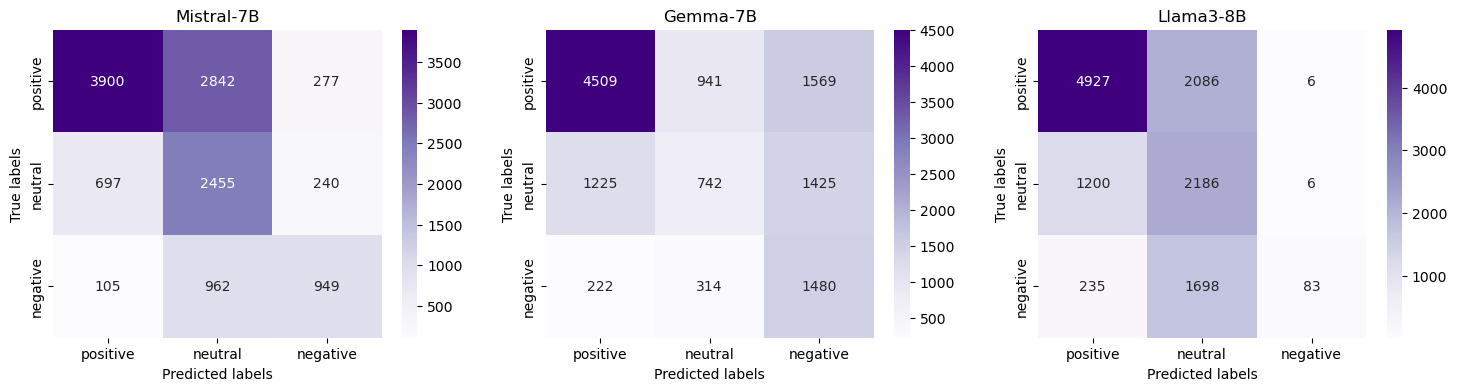

In [46]:
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

# Compute the confusion matrix
cm1 = confusion_matrix(sdf[sdf["model_id"] == "mistral 7b"]["actual_sentiment"], sdf[sdf["model_id"] == "mistral 7b"]["generated_sentiment"], labels=['positive', 'neutral', 'negative'])
sns.heatmap(cm1, annot=True, fmt='d', cmap='Purples', ax=axes[0], xticklabels=['positive', 'neutral', 'negative'], yticklabels=['positive', 'neutral', 'negative'])
cm2 = confusion_matrix(sdf[sdf["model_id"] == "gemma 7b"]["actual_sentiment"], sdf[sdf["model_id"] == "gemma 7b"]["generated_sentiment"], labels=['positive', 'neutral', 'negative'])
sns.heatmap(cm2, annot=True, fmt='d', cmap='Purples', ax=axes[1], xticklabels=['positive', 'neutral', 'negative'], yticklabels=['positive', 'neutral', 'negative'])
cm3 = confusion_matrix(sdf[sdf["model_id"] == "llama 3 8b"]["actual_sentiment"], sdf[sdf["model_id"] == "llama 3 8b"]["generated_sentiment"], labels=['positive', 'neutral', 'negative'])
sns.heatmap(cm3, annot=True, fmt='d', cmap='Purples', ax=axes[2], xticklabels=['positive', 'neutral', 'negative'], yticklabels=['positive', 'neutral', 'negative'])

axes[0].set_title('Mistral-7B')
axes[0].set_xlabel('Predicted labels')
axes[0].set_ylabel('True labels')

axes[1].set_title('Gemma-7B')
axes[1].set_xlabel('Predicted labels')
axes[1].set_ylabel('True labels')

axes[2].set_title('Llama3-8B')
axes[2].set_xlabel('Predicted labels')
axes[2].set_ylabel('True labels')

fig.suptitle("Confusion Matrix for Sentiment Analysis: Mistral-7B Outperforming Others", fontsize=10)

In [6]:
gemma_scores_df = pd.read_csv("/pub/gaog5/copilot/Datasets/gemma_sample_scores.csv")
gemma_scores_df["model_id"] = "Gemma-7B"
gemma_scores_df.describe()

,dialogue_id,rouge_1,rouge_2,rouge_l,bert_precision,bert_recall,bert_f1,meteor
count,12427.000000,12427.000000,12427.000000,12427.000000,12427.000000,12427.000000,12427.000000,12427.000000
mean,6214.000000,0.118819,0.005909,0.110966,0.838960,0.846721,0.842705,0.161631
std,3587.510232,0.052359,0.013656,0.048549,0.014806,0.019478,0.014106,0.088608
min,1.000000,0.000000,0.000000,0.000000,0.774937,0.781306,0.796645,0.018182
25%,3107.500000,0.082192,0.000000,0.076923,0.829413,0.833806,0.833101,0.100671
50%,6214.000000,0.116279,0.000000,0.108108,0.839297,0.845555,0.841897,0.135135
75%,9320.500000,0.151515,0.000000,0.142857,0.848856,0.858751,0.851118,0.199203
max,12427.000000,0.468085,0.259259,0.468085,0.897227,0.931543,0.912278,0.669124


In [9]:
cols = ["model_id", "rouge_1", "rouge_2", "meteor", "bert_f1"]
mistral_df = df[cols]
mistral_df["model_id"] = "Mistral-7B"
df_combined = pd.concat([mistral_df, gemma_scores_df[cols]], ignore_index=True)

melted_df = df_combined.melt(id_vars='model_id', var_name='metric', value_name='score')
melted_df.head()

/tmp/ipykernel_1763040/3114997497.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mistral_df["model_id"] = "Mistral-7B"


,model_id,metric,score
0,Mistral-7B,rouge_1,0.351351
1,Mistral-7B,rouge_1,0.250000
2,Mistral-7B,rouge_1,0.367347
3,Mistral-7B,rouge_1,0.233333
4,Mistral-7B,rouge_1,0.392857


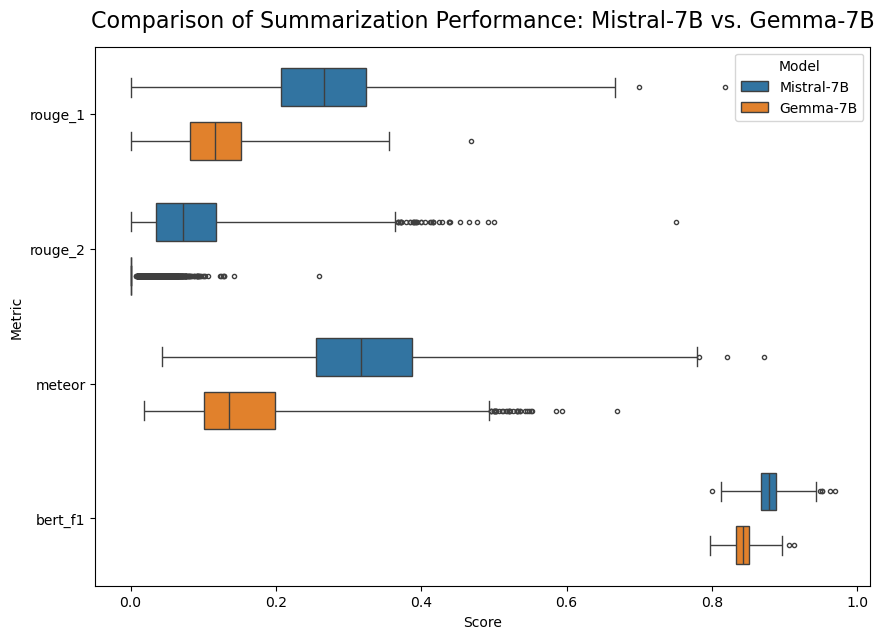

In [10]:
plt.figure(figsize=(10, 7))
ax = sns.boxplot(x='score', y='metric', hue='model_id', data=melted_df, gap=0.3, fliersize=3, whis=3)
plt.title('Comparison of Summarization Performance: Mistral-7B vs. Gemma-7B', fontsize=16, pad=14)
plt.xlabel('Score')
plt.ylabel('Metric')
plt.legend(title='Model')
# plt.grid(axis='y', linestyle='--', linewidth=0.7)

plt.show()

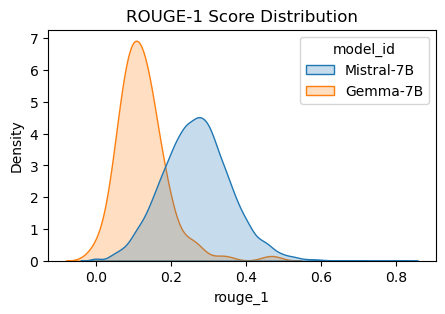

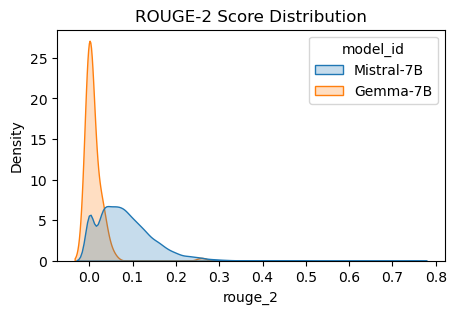

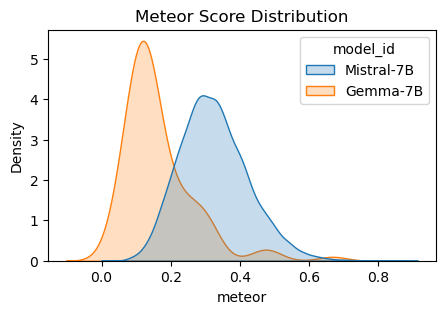

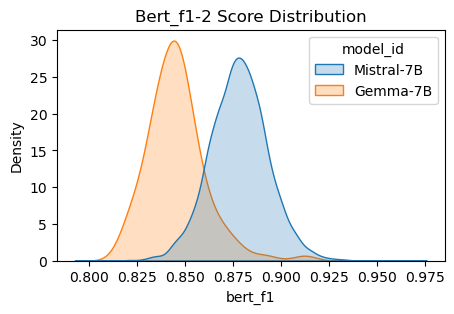

In [ ]:
# Density Plot
plt.figure(figsize=(5, 3))
sns.kdeplot(data=df_combined, x='rouge_1', hue='model_id', fill=True, common_norm=False)
plt.title('ROUGE-1 Score Distribution')
plt.show()

plt.figure(figsize=(5, 3))
sns.kdeplot(data=df_combined, x='rouge_2', hue='model_id', fill=True, common_norm=False)
plt.title('ROUGE-2 Score Distribution')
plt.show()

# Density Plot
plt.figure(figsize=(5, 3))
sns.kdeplot(data=df_combined, x='meteor', hue='model_id', fill=True, common_norm=False)
plt.title('Meteor Score Distribution')
plt.show()

plt.figure(figsize=(5, 3))
sns.kdeplot(data=df_combined, x='bert_f1', hue='model_id', fill=True, common_norm=False)
plt.title('Bert_f1-2 Score Distribution')
plt.show()


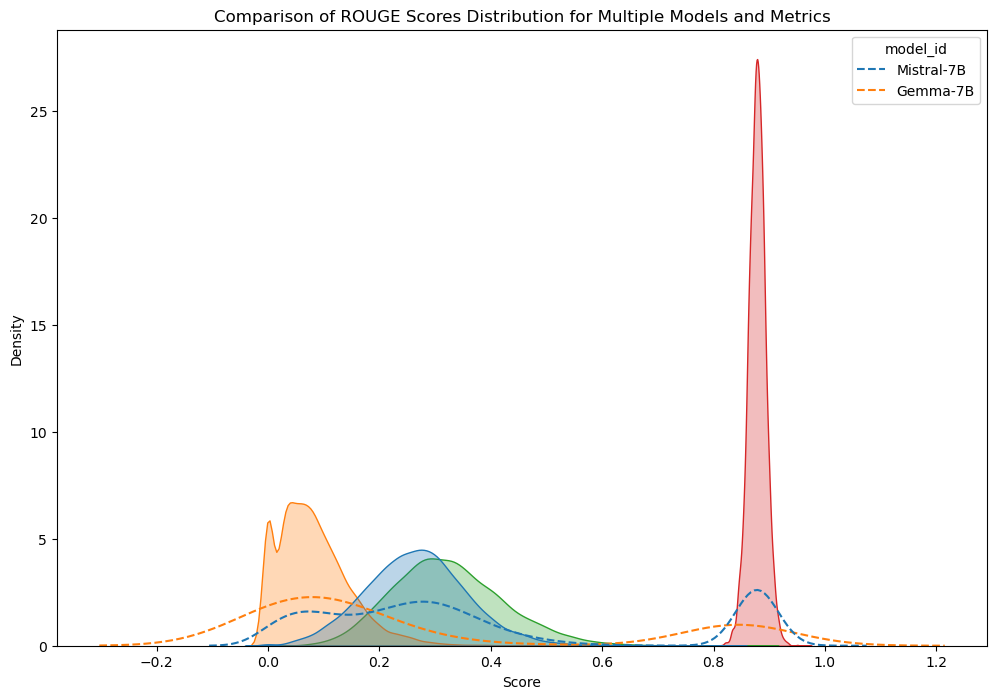

In [ ]:
plt.figure(figsize=(12, 8))
sns.kdeplot(data=melted_df, x='score', hue='metric', fill=True, common_norm=False, palette="tab10", alpha=0.3)
sns.kdeplot(data=melted_df, x='score', hue='model_id', fill=False, common_norm=False, palette="tab10", linestyle="--")
plt.title('Comparison of ROUGE Scores Distribution for Multiple Models and Metrics')
plt.xlabel('Score')
plt.ylabel('Density')
plt.show()

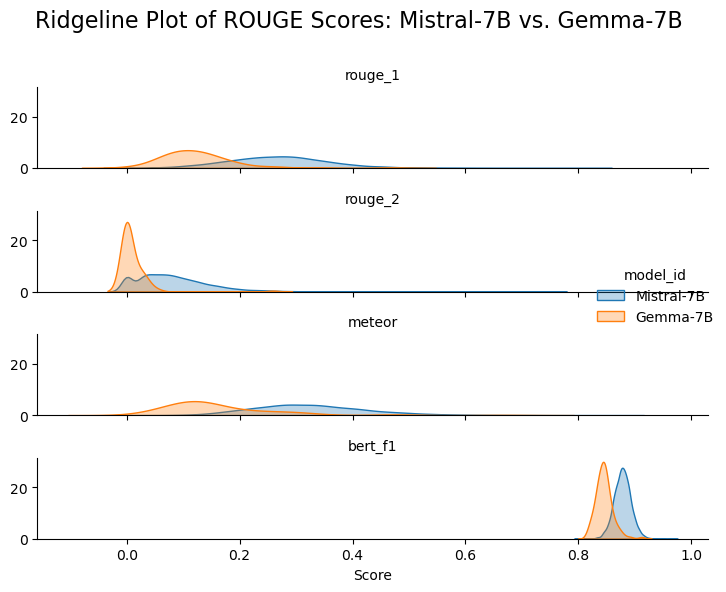

In [ ]:
g = sns.FacetGrid(melted_df, row='metric', hue='model_id', aspect=4, height=1.5)
g.map(sns.kdeplot, 'score', fill=True, alpha=0.3)
g.set_titles(row_template="{row_name}")
g.set_axis_labels("Score", "")
g.figure.suptitle("Ridgeline Plot of ROUGE Scores: Mistral-7B vs. Gemma-7B", fontsize=16)
g.add_legend()
g.figure.tight_layout(rect=[0, 0, 1, 0.97])

plt.show()

In [4]:
mistral_time_memory_df = pd.read_csv("/pub/gaog5/copilot/Datasets/mistral_summary_results.csv")
gemma_time_memory_df = pd.read_csv("/pub/gaog5/copilot/Datasets/gemma_summary_results.csv")
mistral_time_memory_df.describe()

,dialogue_id,Time Taken (s),GPU Usage (MB)
count,12427.000000,12427.000000,12427.000000
mean,6214.000000,0.644041,236.850986
std,3587.510232,0.082565,19.032949
min,1.000000,0.482282,188.913262
25%,3107.500000,0.587857,224.003184
50%,6214.000000,0.632349,236.717480
75%,9320.500000,0.682641,247.919434
max,12427.000000,0.967282,311.105488


In [5]:
gemma_time_memory_df.describe()

,dialogue_id,Time Taken (s),GPU Usage (MB)
count,12427.000000,12427.000000,12427.000000
mean,6214.000000,0.746005,823.424249
std,3587.510232,0.083330,56.595262
min,1.000000,0.553492,656.576250
25%,3107.500000,0.681030,784.726914
50%,6214.000000,0.738925,825.625820
75%,9320.500000,0.814531,863.859883
max,12427.000000,1.183100,1011.066914


In [11]:
llama3_time_memory_df = pd.read_csv("/pub/gaog5/copilot/Datasets/llama3_summary_results.csv")
llama3_time_memory_df.columns = ["dialogue_id", "Summary", "Time Taken (s)", "GPU Usage (MB)"]
llama3_time_memory_df.describe()

,dialogue_id,Time Taken (s),GPU Usage (MB)
count,12427.000000,12427.000000,12427.000000
mean,6214.000000,1.001355,337.338893
std,3587.510232,0.376165,134.385868
min,1.000000,0.755299,231.349043
25%,3107.500000,0.821449,268.121973
50%,6214.000000,0.835025,281.496660
75%,9320.500000,0.866487,300.746582
max,12427.000000,3.432660,1190.739219


In [12]:
cols = ["Time Taken (s)", "GPU Usage (MB)"]
mistral_time_memory_df = mistral_time_memory_df[cols]
mistral_time_memory_df["Model"] = "Mistral-7B"

gemma_time_memory_df = gemma_time_memory_df[cols]
gemma_time_memory_df["Model"] = "Gemma-7B"

llama3_time_memory_df = llama3_time_memory_df[cols]
llama3_time_memory_df["Model"] = "Llama3-8B"

time_memory_df_combined = pd.concat([mistral_time_memory_df, gemma_time_memory_df, llama3_time_memory_df], ignore_index=True)

time_memory_df_combined

,Time Taken (s),GPU Usage (MB),Model
0,0.554711,213.601387,Mistral-7B
1,0.554711,213.601387,Mistral-7B
2,0.554711,213.601387,Mistral-7B
3,0.554711,213.601387,Mistral-7B
4,0.554711,213.601387,Mistral-7B
...,...,...,...
37276,1.690911,572.917734,Llama3-8B
37277,0.830272,277.273711,Llama3-8B
37278,0.877787,310.952031,Llama3-8B
37279,0.830272,277.273711,Llama3-8B


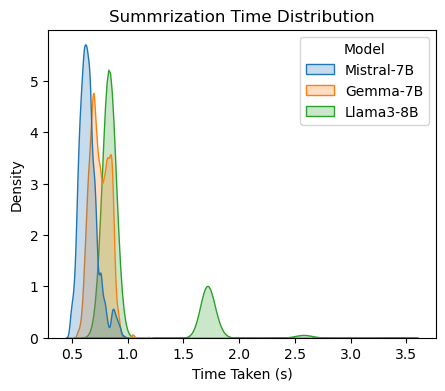

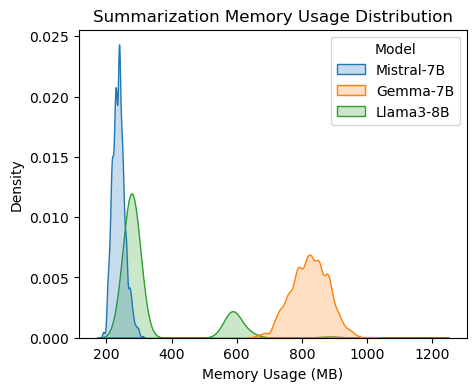

In [13]:
plt.figure(figsize=(5, 4))
sns.kdeplot(data=time_memory_df_combined, x='Time Taken (s)', hue='Model', fill=True, common_norm=False)
plt.title('Summrization Time Distribution')
plt.show()

plt.figure(figsize=(5, 4))
sns.kdeplot(data=time_memory_df_combined, x='GPU Usage (MB)', hue='Model', fill=True, common_norm=False)
plt.title('Summarization Memory Usage Distribution')
plt.xlabel("Memory Usage (MB)")
plt.show()